# Семинар: Алгоритмы поиска и планирования в задаче уклонения от преследователя

В этом семинаре мы погрузимся в мир поиска пути и планирования в динамической среде. Наша задача — помочь агенту (уклоняющемуся) добраться до цели в лабиринте, избегая преследователя. Мы реализуем и сравним несколько подходов:

1.  **Классические алгоритмы поиска:** Дейкстра и A*. Эти алгоритмы находят оптимальный путь в *статической* среде, где нет преследователя.
2.  **Алгоритм планирования:** Монте-Карло по деревьям (MCTS). Этот метод способен учитывать динамику среды и планировать действия, моделируя будущие сценарии, включая поведение преследователя.

Мы будем использовать среду лабиринта, которую можно загрузить из файла или сгенерировать случайным образом. В процессе вы сможете не только наблюдать за работой алгоритмов, но и написать ключевые части кода сами!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math
from IPython.display import clear_output, Video
import os
import imageio
from typing import Tuple, List, Dict, Any, Optional

# Убедимся, что папка для видео существует
os.makedirs("videos", exist_ok=True)

# Определим возможные действия (вверх, вниз, влево, вправо)
# (dy, dx): (y-1,x) = вверх, (y+1,x) = вниз, (y,x-1) = влево, (y,x+1) = вправо
action_space = [(-1, 0), (1, 0), (0, -1), (0, 1)] # (dy, dx): вверх, вниз, влево, вправо
n_actions = len(action_space)

## 1. Загрузка и инициализация среды

Первым делом нам нужно определить нашу среду — лабиринт. Мы поддерживаем три способа его инициализации:
1.  **Загрузка из файла** (`maze.npz`): Позволяет использовать заранее подготовленные сценарии.
2.  **Случайная генерация**: Полезно для тестирования на разнообразных картах.
3.  **Дефолтный лабиринт**: Предопределённый пример, который мы будем использовать для демонстрации.

Также мы определим функцию перехода для нашего агента, которая проверяет, можно ли перейти в соседнюю клетку (не является ли она стеной или границей лабиринта).

Выберите тип лабиринта:
1. Загрузить из файла 'maze.npz'
2. Сгенерировать случайный
3. Использовать дефолтный (из примера)
Введите номер (1, 2 или 3): 3
Используется дефолтный лабиринт.
Размер лабиринта: (30, 30)
Старт уклоняющегося: (11, 6)
Цель: (15, 29)
Старт преследователя: (7, 25)


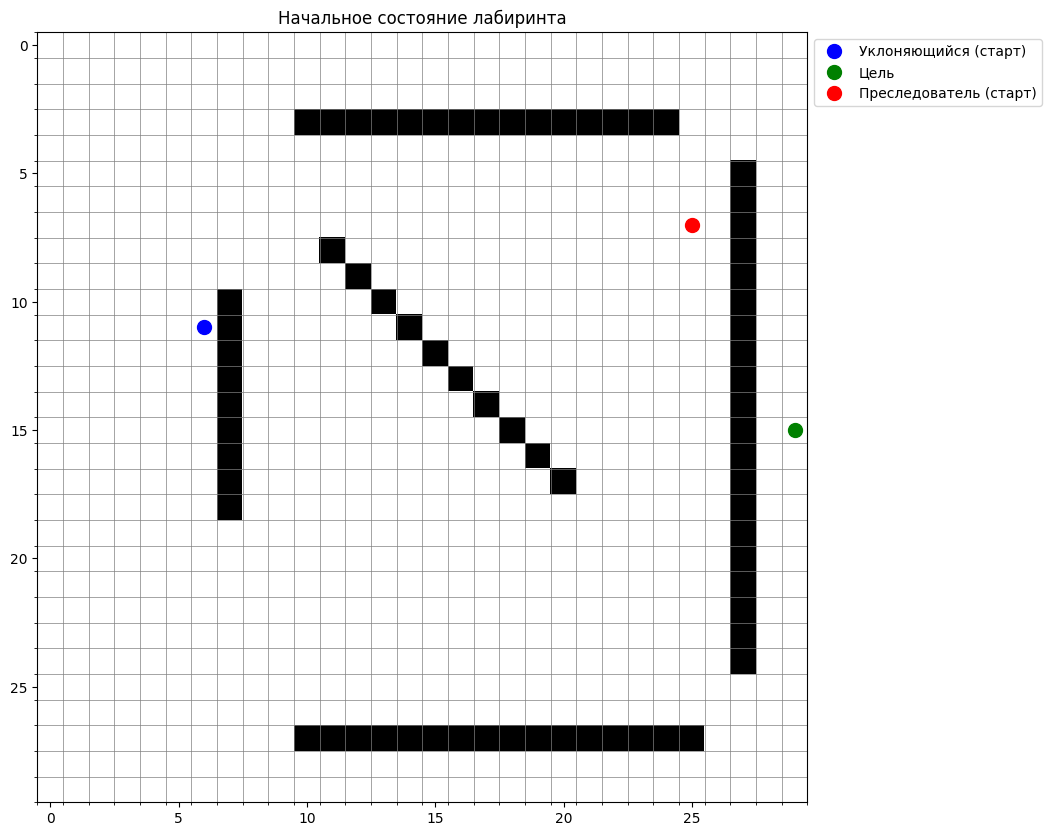

In [ ]:
def transition_function(env_map: np.ndarray, pos: Tuple[int, int], action: Tuple[int, int]) -> Tuple[Tuple[int, int], bool]:
    """
    Функция перехода для агента (уклоняющегося).

    Args:
        env_map (np.ndarray): Бинарная карта лабиринта (0 - проход, 1 - стена).
        pos (Tuple[int, int]): Текущая позиция (y, x).
        action (Tuple[int, int]): Действие (dy, dx).

    Returns:
        Tuple[Tuple[int, int], bool]: Новая позиция и флаг, можно ли туда перейти.
    """
    dy, dx = action
    y, x = pos
    new_y, new_x = y + dy, x + dx

    if 0 <= new_y < env_map.shape[0] and 0 <= new_x < env_map.shape[1] and env_map[new_y, new_x] == 0: #проверяем границы
        return (new_y, new_x), True
    else:
        return pos, False  #если граница или препятствие, остаёмся на месте

# --- Загрузка из .npz файла ---
def load_maze_from_file(filename: str):
    """
    Загружает лабиринт из .npz файла.

    Args:
        filename (str): Путь к .npz файлу.

    Returns:
        Tuple[np.ndarray, Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]:
        (карта, старт уклоняющегося, цель, старт преследователя, цель преследователя).
    """
    data = np.load(filename)
    maze = data['environment']
    goal = tuple(data['goal'])
    x_e_start = tuple(data['x_e'])
    x_p_start = tuple(data['x_p'])
    # В задании не всегда определена цель преследователя, используем цель уклоняющегося
    x_p_goal = goal
    return maze, x_e_start, goal, x_p_start, x_p_goal

# --- Генерация случайного лабиринта ---
def generate_random_maze(height: int, width: int, wall_density: float = 0.2):
    """
    Генерирует случайный лабиринт.

    Args:
        height (int): Высота лабиринта.
        width (int): Ширина лабиринта.
        wall_density (float): Вероятность, что клетка - стена (0.0 - 1.0).

    Returns:
        Tuple[np.ndarray, Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]:
        (карта, старт уклоняющегося, цель, старт преследователя, цель преследователя).
    """
    maze = np.random.choice([0, 1], size=(height, width), p=[1-wall_density, wall_density])
    # Убедимся, что старт и цель - проходы
    maze[0, 0] = 0
    maze[height-1, width-1] = 0
    maze[0, width-1] = 0 # Старт преследователя
    evader_start = (0, 0)
    goal = (height-1, width-1)
    pursuer_start = (0, width-1)
    pursuer_goal = goal # Преследователь стремится к цели уклоняющегося
    return maze, evader_start, goal, pursuer_start, pursuer_goal

# --- Дефолтный лабиринт ---
def get_default_maze():
    """
    Возвращает предопределённый лабиринт, стартовые позиции и цель.

    Returns:
        Tuple[np.ndarray, Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]:
        (карта, старт уклоняющегося, цель, старт преследователя, цель преследователя).
    """
    # Используем структуру лабиринта из первого файла (примерный размер и форма)
    maze = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
    # Позиции из примера в первом файле
    evader_start = (11, 6) # (y, x)
    goal = (15, 29)        # (y, x)
    pursuer_start = (7, 25) # (y, x)
    pursuer_goal = goal
    return maze, evader_start, goal, pursuer_start, pursuer_goal

# --- Визуализация начального состояния ---
def visualize_initial_state(env_map, evader_start, goal, pursuer_start, title="Начальное состояние лабиринта"):
    """
    Визуализирует лабиринт с начальными позициями уклоняющегося, преследователя и цели.
    Все позиции заданы как (y, x).
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Отображаем карту с правильной ориентацией
    ax.imshow(env_map, cmap='Greys', origin='upper')

    # Отмечаем позиции: (x, y) = (pos[1], pos[0])
    ax.plot(evader_start[1], evader_start[0], 'bo', markersize=10, label='Уклоняющийся (старт)')
    ax.plot(goal[1], goal[0], 'go', markersize=10, label='Цель')
    ax.plot(pursuer_start[1], pursuer_start[0], 'ro', markersize=10, label='Преследователь (старт)')

    # Настройка пределов
    ax.set_xlim(-0.5, env_map.shape[1] - 0.5)
    ax.set_ylim(env_map.shape[0] - 0.5, -0.5)  # Инвертируем ось Y

    # Сетка по границам ячеек
    ax.set_xticks(np.arange(-0.5, env_map.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env_map.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

    ax.set_title(title)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
# --- Выбор и инициализация среды ---
print("Выберите тип лабиринта:")
print("1. Загрузить из файла 'maze.npz'")
print("2. Сгенерировать случайный")
print("3. Использовать дефолтный (из примера)")
choice = input("Введите номер (1, 2 или 3): ")

if choice == '1':
    try:
        maze_default, evader_start_default, goal_default, pursuer_start_default, pursuer_goal_default = load_maze_from_file('maze.npz')
        print("Лабиринт загружен из файла 'maze.npz'.")
    except FileNotFoundError:
        print("Файл 'maze.npz' не найден. Используем случайный лабиринт.")
        maze_default, evader_start_default, goal_default, pursuer_start_default, pursuer_goal_default = generate_random_maze(30, 30, wall_density=0.2)
elif choice == '2':
    maze_default, evader_start_default, goal_default, pursuer_start_default, pursuer_goal_default = generate_random_maze(30, 30, wall_density=0.2)
    print("Случайный лабиринт сгенерирован.")
else:
    maze_default, evader_start_default, goal_default, pursuer_start_default, pursuer_goal_default = get_default_maze()
    print("Используется дефолтный лабиринт.")

print(f"Размер лабиринта: {maze_default.shape}")
print(f"Старт уклоняющегося: {evader_start_default}")
print(f"Цель: {goal_default}")
print(f"Старт преследователя: {pursuer_start_default}")

# Визуализируем начальное состояние
visualize_initial_state(maze_default, evader_start_default, goal_default, pursuer_start_default)

## 2. Преследователь и его стратегия

Теперь давайте определим поведение преследователя. В нашем сценарии преследователь следует простой, но эффективной **жадной стратегии**: на каждом шаге он выбирает действие, которое минимизирует манхэттенское расстояние до текущей позиции уклоняющегося. Это означает, что преследователь всегда движется напрямую к уклоняющемуся, не планируя его будущие ходы.

Эта стратегия позволяет нам создать динамическую среду, в которой уклоняющийся не может просто следовать заранее вычисленному статическому пути — он должен адаптироваться к движениям преследователя.

In [ ]:
def manhattan_distance(pos1, pos2):
    """Вычисляет манхэттенское расстояние между двумя точками (y, x)."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

#слишком просто!
def pursuer_transition_boring(env_map: np.ndarray, evader_pos: Tuple[int, int], pursuer_pos: Tuple[int, int]) -> Tuple[int, int]:
    """
    Функция перехода для преследователя. Пытается приблизиться к уклоняющемуся.
    Использует жадную стратегию: выбирает действие, минимизирующее манхэттенское расстояние до evader_pos.

    Args:
        env_map (np.ndarray): Бинарная карта лабиринта (0 - проход, 1 - стена).
        evader_pos (Tuple[int, int]): Позиция уклоняющегося (y, x).
        pursuer_pos (Tuple[int, int]): Позиция преследователя (y, x).

    Returns:
        Tuple[int, int]: Новая позиция преследователя (y, x).
    """
    py, px = pursuer_pos
    ey, ex = evader_pos

    possible_moves = []
    for dy, dx in action_space:
        new_py, new_px = py + dy, px + dx
        if 0 <= new_py < env_map.shape[0] and 0 <= new_px < env_map.shape[1] and env_map[new_py, new_px] == 0:
            dist = manhattan_distance((new_py, new_px), (ey, ex))
            possible_moves.append(((new_py, new_px), dist))

    if not possible_moves:
        return pursuer_pos

    best_pos, _ = min(possible_moves, key=lambda x: x[1])
    return best_pos

# --- Тестирование функций ---
print("--- Тестирование функций transition_function и pursuer_transition ---")

# Простой тестовый лабиринт 5x5
test_maze = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
])



--- Тестирование функций transition_function и pursuer_transition ---


## Обновлённая стратегия преследователя: Угловая вероятностная навигация

Мы заменяем простую жадную стратегию (минимизация манхэттенского расстояния) на более реалистичную и гибкую политику, основанную на **угловом направлении к цели**.

**Интуиция поведения:**
- Преследователь "смотрит" на уклоняющегося и определяет **направление** к нему как угол в полярной системе координат.
- Этот угол преобразуется в диапазон `[0, 4)`, где каждая единица соответствует одному из четырёх базовых действий:  
  `0 → вверх`, `1 → вправо`, `2 → вниз`, `3 → влево`.
- Если уклоняющийся находится точно по диагонали (например, вправо-вниз), угол будет ≈1.5.  
  В этом случае преследователь **случайно выбирает** между "вправо" и "вниз" с вероятностью, пропорциональной близости к каждому направлению.
- Это имитирует естественное, неидеальное поведение: агент не всегда движется строго по сетке, а может "колебаться" между двумя направлениями.
- **С 5% вероятностью** преследователь делает **два хода за один шаг**, что повышает его угрозу и делает поведение менее предсказуемым.

Такой подход позволяет преследователю **действительно наступать на уклоняющегося**, если тот находится в соседней клетке, поскольку целевая клетка является проходимой и лежит в направлении движения.

In [ ]:
def pursuer_policy(x_e: Tuple[int, int], x_p: Tuple[int, int]) -> int:
    """
    Возвращает индекс действия для преследователя на основе направления к уклоняющемуся.

    Интуиция:
    Преследователь смотрит на вектор от своей позиции к позиции уклоняющегося: (dy, dx) = (y_e - y_p, x_e - x_p).
    Затем он вычисляет угол этого вектора с помощью arctan2(dx, dy) — обратите внимание на порядок!
    Это необходимо, потому что в нашей системе координат:
      - ось Y направлена вниз (строки),
      - ось X — вправо (столбцы),
      - а действия заданы как: [вверх (-1,0), вниз (+1,0), влево (0,-1), вправо (0,+1)].

    Угол нормализуется в диапазон [0, 4), где каждая единица соответствует одному из 4 действий.
    Выбор действия делается с линейной интерполяцией: если угол находится между двумя направлениями,
    преследователь случайно выбирает одно из них с вероятностью, пропорциональной близости к каждому.

    Это имитирует "естественное" поведение: преследователь не всегда движется строго по сетке,
    а может "колебаться" между двумя направлениями, если цель находится по диагонали.

    Args:
        x_e (Tuple[int, int]): Позиция уклоняющегося (y, x).
        x_p (Tuple[int, int]): Позиция преследователя (y, x).

    Returns:
        int: Индекс действия из action_space (0 — вверх, 1 — вниз, 2 — влево, 3 — вправо).
    """
    # Вектор от преследователя к уклоняющемуся: (Δy, Δx)
    dy = x_e[0] - x_p[0]
    dx = x_e[1] - x_p[1]

    # Вычисляем угол в радианах. Важно: arctan2(dx, dy), а не (dy, dx)!
    # Потому что в стандартной системе координат atan2(y, x), а у нас:
    # - "вперёд" — это уменьшение y (вверх), что соответствует отрицательному y в декартовой системе.
    # Чтобы согласовать направления, мы считаем угол относительно оси Y.
    theta = np.arctan2(dx, dy)  # угол относительно оси Y (вперёд = вверх)

    # Преобразуем угол из [-π, π] в [0, 4)
    # 0 → вверх, 1 → вправо, 2 → вниз, 3 → влево
    theta_norm = (theta + np.pi) / (2 * np.pi) * 4  # [0, 4)

    # Определяем основное направление
    u_index = int(np.floor(theta_norm)) % 4
    delta = theta_norm - np.floor(theta_norm)  # доля между u_index и (u_index+1)

    # С вероятностью delta выбираем следующее направление
    if np.random.rand() < delta:
        u_index = (u_index + 1) % 4

    return u_index


def pursuer_transition(env_map: np.ndarray, evader_pos: Tuple[int, int], pursuer_pos: Tuple[int, int]) -> Tuple[int, int]:
    """
    Функция перехода для преследователя с вероятностной угловой политикой.
    С 5% вероятностью делает двойной ход (два последовательных действия).

    Args:
        env_map (np.ndarray): Бинарная карта лабиринта (0 - проход, 1 - стена).
        evader_pos (Tuple[int, int]): Позиция уклоняющегося (y, x).
        pursuer_pos (Tuple[int, int]): Позиция преследователя (y, x).

    Returns:
        Tuple[int, int]: Новая позиция преследователя (y, x).
    """
    # Определяем, сколько ходов сделать: 1 или 2 (с 5% вероятностью)
    iters = 1
    if np.random.rand() < 0.05:
        iters = 2

    # Выполняем заданное количество ходов
    current_pos = pursuer_pos
    for _ in range(iters):
        # Получаем индекс действия от политики
        action_idx = pursuer_policy(evader_pos, current_pos)
        action = action_space[action_idx]
        # Применяем переход (с учётом стен и границ)
        new_pos, is_valid = transition_function(env_map, current_pos, action)
        # Даже если ход недействителен (стена), остаёмся на месте — transition_function это обеспечивает
        current_pos = new_pos

    return current_pos

In [ ]:
# Тест transition_function
start_pos = (0, 0)  # (y, x)
action_right = (0, 1)  # (dy, dx) → (0, +1)
new_pos, success = transition_function(test_maze, start_pos, action_right)
print(f"Тест transition_function: {start_pos} + {action_right} -> {new_pos}, успех: {success}")

action_down = (1, 0)  # (dy, dx) → (+1, 0)
new_pos, success = transition_function(test_maze, new_pos, action_down)
print(f"Тест transition_function: {new_pos} + {action_down} -> {new_pos}, успех: {success}")

# Тест pursuer_transition
evader_pos = (4, 4)  # (y, x)
pursuer_pos = (0, 4)  # (y, x)
new_pursuer_pos = pursuer_transition(test_maze, evader_pos, pursuer_pos)
print(f"Тест pursuer_transition: Преследователь {pursuer_pos} -> {new_pursuer_pos}, уклоняющийся в {evader_pos}")

Тест transition_function: (0, 0) + (0, 1) -> (0, 1), успех: True
Тест transition_function: (0, 1) + (1, 0) -> (0, 1), успех: False
Тест pursuer_transition: Преследователь (0, 4) -> (0, 3), уклоняющийся в (4, 4)



=== Тест визуализации переходов ===
Переход из (0, 0) по действию (0, 1) → (np.int64(0), np.int64(1)), успех: True


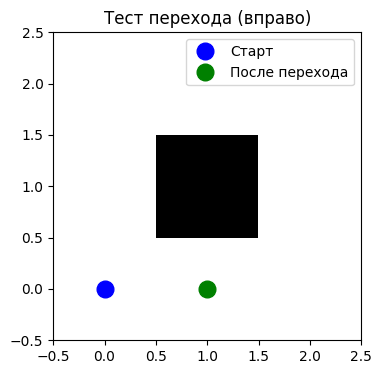

Преследователь из (0, 2) → (np.int64(0), np.int64(0)) при уклоняющемся в (2, 2)


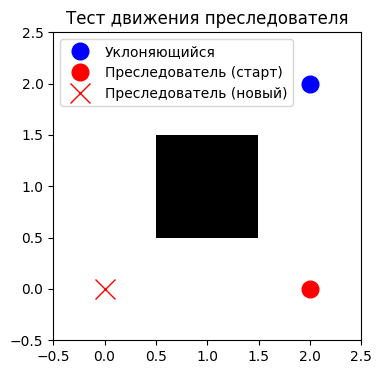

In [ ]:
# --- Тест визуализации переходов вне алгоритмов ---
print("\n=== Тест визуализации переходов ===")
test_maze_small = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])
pos = (0, 0)  # (y, x)
action = (0, 1)  # вправо
new_pos, ok = transition_function(test_maze_small, pos, action)
print(f"Переход из {pos} по действию {action} → {new_pos}, успех: {ok}")

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(test_maze_small, cmap='Greys')
ax.plot(pos[1], pos[0], 'bo', markersize=12, label='Старт')
ax.plot(new_pos[1], new_pos[0], 'go', markersize=12, label='После перехода')
ax.legend()
ax.set_title("Тест перехода (вправо)")
ax.invert_yaxis()
plt.show()

# Тест преследователя
ev_pos = (2, 2)
purs_pos = (0, 2)
new_purs = pursuer_transition(test_maze_small, ev_pos, purs_pos)
print(f"Преследователь из {purs_pos} → {new_purs} при уклоняющемся в {ev_pos}")

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(test_maze_small, cmap='Greys')
ax.plot(ev_pos[1], ev_pos[0], 'bo', markersize=12, label='Уклоняющийся')
ax.plot(purs_pos[1], purs_pos[0], 'ro', markersize=12, label='Преследователь (старт)')
ax.plot(new_purs[1], new_purs[0], 'rx', markersize=15, label='Преследователь (новый)')
ax.legend()
ax.set_title("Тест движения преследователя")
ax.invert_yaxis()
plt.show()

## 3. Классические алгоритмы поиска: Дейкстра

Алгоритм Дейкстры — это фундаментальный алгоритм для нахождения кратчайшего пути от одной вершины графа до всех остальных. В контексте лабиринта:
*   **Вершины графа** — это клетки лабиринта.
*   **Рёбра** — это возможные переходы между соседними клетками.
*   **Вес рёбер** — обычно равен 1 (стоимость одного шага).

Алгоритм работает, поддерживая таблицу `distances`, в которой хранится текущая минимальная известная стоимость пути от стартовой позиции до каждой клетки. Он использует очередь с приоритетом, чтобы всегда обрабатывать клетку с наименьшей известной стоимостью, обновляя стоимости её соседей. В результате мы получаем карту стоимостей `G*` и можем восстановить оптимальную политику (направление движения) для каждой клетки.

**Важно:** Дейкстра находит оптимальный путь только в *статической* среде, без преследователя. Мы будем использовать его как базовую линию для сравнения.

In [ ]:
def dijkstra(env_map, start, goal):
    """
    Реализует алгоритм Дейкстры для поиска кратчайшего пути от start до goal.
    Возвращает массив стоимостей G* и массив предшественников.
    Все позиции — (y, x).

    Args:
        env_map (np.ndarray): Бинарная карта лабиринта (0 — проход, 1 — стена).
        start (Tuple[int, int]): Начальная позиция (y, x).
        goal (Tuple[int, int]): Целевая позиция (y, x).

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - distances: массив минимальных стоимостей до каждой точки.
            - predecessors: массив предшественников для восстановления пути.
    """
    height, width = env_map.shape

    # Инициализация массива минимальных стоимостей (G*). Стены и не посещённые клетки = inf.
    distances = np.full((height, width), np.inf, dtype=float)

    # Массив предшественников: для восстановления пути. Каждая клетка хранит предыдущую.
    predecessors = np.empty((height, width), dtype=object)
    predecessors.fill(None)

    # Массив для отслеживания посещённых клеток, чтобы не обрабатывать дважды.
    visited = np.zeros((height, width), dtype=bool)

    # Очередь с приоритетом (мин-куча): хранит (стоимость, позиция).
    pq = [(0, start)]
    distances[start] = 0  # Стоимость до стартовой точки — 0.

    while pq:
        # Извлекаем узел с минимальной стоимостью
        current_dist, current_pos = heapq.heappop(pq)

        # Если уже посещён — пропускаем (защита от повторных вычислений)
        if visited[current_pos]:
            continue

        # Помечаем как посещённый
        visited[current_pos] = True

        # Перебираем все возможные действия (вверх, вниз, влево, вправо)
        for action in action_space:
            neighbor_pos, is_valid = transition_function(env_map, current_pos, action)

            # Если переход валиден и сосед не посещён
            if is_valid and not visited[neighbor_pos]:
                # Вычисляем новую стоимость до соседа
                ### ВАШ КОД
                new_dist =...
                ### КОНЕЦ

                # Если найден более короткий путь — обновляем
                ### ВАШ КОД
                if ...:
                ### КОНЕЦ
                    distances[neighbor_pos] = new_dist
                    predecessors[neighbor_pos] = current_pos  # Запоминаем, откуда пришли
                    # Добавляем соседа в очередь с новой стоимостью
                    heapq.heappush(pq, (new_dist, neighbor_pos))

    return distances, predecessors

def get_policy_from_predecessors(predecessors, start, goal):
    """
    Восстанавливает политику (действия к цели) из массива предшественников.
    Политика определена только для клеток на оптимальном пути от start к goal.

    Args:
        predecessors (np.ndarray): Массив предшественников, полученный из Дейкстры или A*.
        start (Tuple[int, int]): Начальная позиция (y, x).
        goal (Tuple[int, int]): Целевая позиция (y, x).

    Returns:
        np.ndarray: Массив, где каждый элемент — это действие (dy, dx), ведущее к цели.
                    Заполнен только для клеток на оптимальном пути.
    """
    height, width = predecessors.shape
    # Инициализируем политику как пустой массив объектов (может содержать None и кортежи)
    policy = np.empty((height, width), dtype=object)
    policy.fill(None)

    # Начинаем восстановление пути от цели к старту
    current = goal

    # Пока не дойдём до стартовой точки или не наткнёмся на отсутствие предшественника
    while current is not None and current != start:
        pred = predecessors[current]  # Получаем предшественника текущей клетки

        # Если предшественник отсутствует, выходим (например, если current — старт или недостижимо)
        if pred is None:
            break

        # Вычисляем действие (dy, dx), которое нужно сделать из предшественника, чтобы попасть в текущую клетку
        dy = current[0] - pred[0]  # Δy
        dx = current[1] - pred[1]  # Δx

        # Сохраняем действие в политике: из клетки `pred` нужно сделать шаг (dy, dx), чтобы продолжить путь к цели
        policy[pred] = (dy, dx)

        # Переходим к предшественнику и продолжаем восстановление
        current = pred

    return policy

In [ ]:
# --- Визуализация тепловой карты G* для Дейкстры ---
def visualize_dijkstra_distances(env_map, distances, goal, title="Тепловая карта стоимости (Дейкстра)"):
    """
    Визуализирует тепловую карту стоимостей G*.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    masked_distances = np.ma.masked_where(env_map == 1, distances)
    im = ax.imshow(masked_distances, cmap='viridis')
    ax.plot(goal[1], goal[0], 'go', markersize=10, label='Цель')
    ax.set_title(title)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.colorbar(im, ax=ax, shrink=0.5)
    plt.show()

### 3.1. Игровой цикл

Теперь, когда у нас есть функции для алгоритма и визуализации, давайте создадим игровой цикл. Этот цикл будет:
1.  Визуализировать текущее состояние лабиринта (агент, преследователь, цель).
2.  Выбирать действие для уклоняющегося на основе его политики.
3.  Обновлять позицию уклоняющегося.
4.  (Опционально) Обновлять позицию преследователя.
5.  Проверять условия завершения (достигнута цель или пойман преследователем).
6.  Сохранять кадры для создания видео.

Мы реализуем этот цикл так, чтобы он мог работать как с преследователем, так и без него.

In [ ]:
def run_game_dijkstra(env_map, policy, evader_start, goal, pursuer_start=None, pursuer_active=False, video_name="dijkstra_game"):
    """
    Запускает игровой цикл с политикой, полученной из Дейкстры.
    Все позиции — (y, x).
    """
    evader_pos = evader_start
    pursuer_pos = pursuer_start
    frames = []
    max_steps = 200
    step = 0

    while step < max_steps:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        # Визуализация карты с правильной ориентацией
        ax.imshow(env_map, cmap='Greys', origin='upper')

        # Отображение позиций: (x, y) = (pos[1], pos[0])
        ax.plot(evader_pos[1], evader_pos[0], 'bo', markersize=10, label='Уклоняющийся')
        ax.plot(goal[1], goal[0], 'go', markersize=10, label='Цель')
        if pursuer_active and pursuer_pos is not None:
            ax.plot(pursuer_pos[1], pursuer_pos[0], 'ro', markersize=10, label='Преследователь')

        ax.set_title(f"Шаг {step}. Уклоняющийся: {evader_pos}, Преследователь: {pursuer_pos}")
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Настройка сетки
        ax.set_xticks(np.arange(-0.5, env_map.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, env_map.shape[0], 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

        ax.set_xlim(-0.5, env_map.shape[1]-0.5)
        ax.set_ylim(env_map.shape[0]-0.5, -0.5)  # Инвертируем ось Y

        filename = f"tmp_frame_{step}.png"
        plt.savefig(filename)
        frames.append(imageio.imread(filename))
        plt.close()
        os.remove(filename)

        # Проверка условий завершения
        if evader_pos == goal:
            print(f"Цель достигнута на шаге {step}!")
            break
        if pursuer_active and evader_pos == pursuer_pos:
            print(f"Пойман преследователем на шаге {step}!")
            break

        # Движение уклоняющегося
        action = policy[evader_pos]
        if action is None:
            print(f"Уклоняющийся в тупике на шаге {step}.")
            break
        evader_pos, _ = transition_function(env_map, evader_pos, action)

        # Движение преследователя
        if pursuer_active and pursuer_pos is not None:
            pursuer_pos = pursuer_transition(env_map, evader_pos, pursuer_pos)
            # Проверка поимки после хода преследователя
            if evader_pos == pursuer_pos:
                print(f"Пойман преследователем после его хода на шаге {step}!")
                break

        step += 1

    video_path = f"videos/{video_name}.mp4"
    imageio.mimsave(video_path, frames, fps=10)
    print(f"Видео сохранено как {video_path}")
    return video_path

Запуск алгоритма Дейкстры...


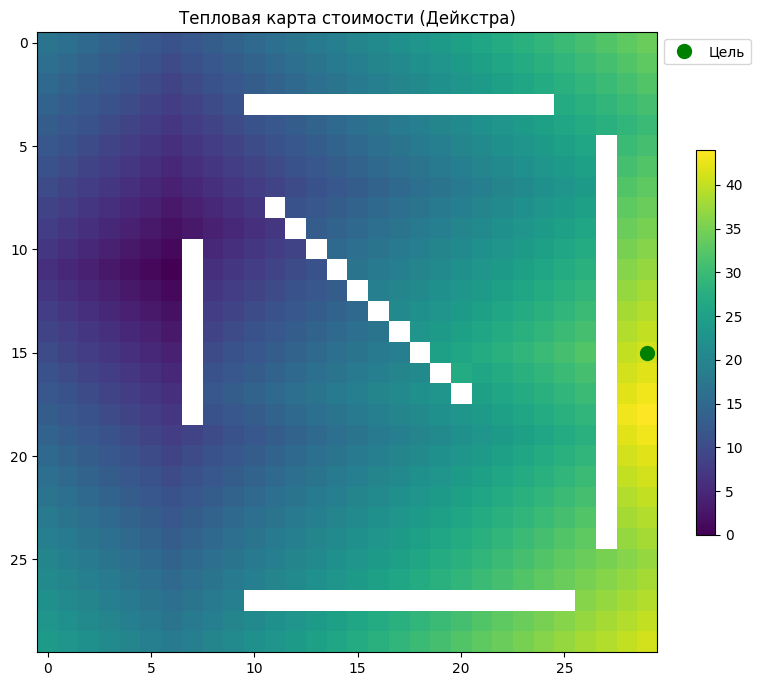


--- Игра с политикой Дейкстры (без преследователя) ---


Цель достигнута на шаге 41!
Видео сохранено как videos/dijkstra_no_pursuer.mp4
Смотрите видео: videos/dijkstra_no_pursuer.mp4


In [ ]:
# --- Запуск Дейкстры ---
print("Запуск алгоритма Дейкстры...")
distances_dijkstra, predecessors_dijkstra = dijkstra(maze_default, evader_start_default, goal_default)
policy_dijkstra = get_policy_from_predecessors(predecessors_dijkstra, evader_start_default, goal_default)

# --- Визуализация G* ---
visualize_dijkstra_distances(maze_default, distances_dijkstra, goal_default)

# --- Игра без преследователя ---
print("\n--- Игра с политикой Дейкстры (без преследователя) ---")
video_path_no_pursuer = run_game_dijkstra(maze_default, policy_dijkstra, evader_start_default, goal_default, video_name="dijkstra_no_pursuer")
print(f"Смотрите видео: {video_path_no_pursuer}")

# --- Игра с преследователем ---
#print("\n--- Игра с политикой Дейкстры (с преследователем) ---")
#video_path_with_pursuer = run_game_dijkstra(maze_default, policy_dijkstra, evader_start_default, goal_default, pursuer_start_default, pursuer_active=True, video_name="dijkstra_with_pursuer")
#print(f"Смотрите видео: {video_path_with_pursuer}")

In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Находим все .mp4 файлы в папке 'videos' и сортируем их по времени изменения (самый свежий — последний)
video_paths = sorted(
    [s for s in Path('videos').iterdir() if s.suffix == '.mp4'],
    key=lambda f: f.stat().st_mtime
)

if not video_paths:
    print("Видео не найдены в папке 'videos'.")
else:
    video_path = video_paths[-1]
    print(f"Воспроизведение видео: {video_path.name}")

    if 'google.colab' in sys.modules:
        with video_path.open('rb') as fp:
            mp4 = fp.read()
        data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    else:
        data_url = str(video_path)

    display(HTML(f"""
    <video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
    </video>
    """))

Воспроизведение видео: dijkstra_no_pursuer.mp4


## 4. Классические алгоритмы поиска: A*

Алгоритм A* — это улучшенная версия Дейкстры, которая использует **эвристическую функцию** `h(n)` для оценки стоимости пути от текущей клетки `n` до цели. Это позволяет алгоритму быть более направленным и часто находить путь быстрее, чем Дейкстра.

Приоритет узла в очереди теперь определяется как `f(n) = g(n) + h(n)`, где:
*   `g(n)` — реальная стоимость пути от старта до `n`.
*   `h(n)` — эвристическая оценка стоимости пути от `n` до цели.

Для нашего лабиринта на сетке с 4-направленным движением отличной эвристикой является **манхэттенское расстояние**. Она допустима (никогда не переоценивает истинную стоимость), что гарантирует оптимальность найденного пути.

Как и Дейкстра, A* находит оптимальный путь в статической среде.


Запуск алгоритма A*...


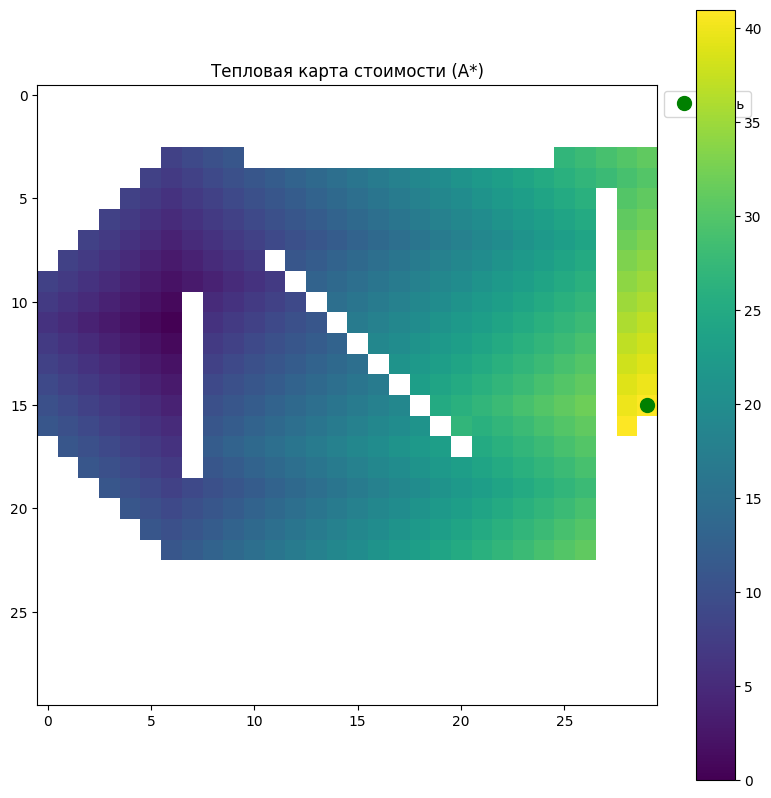


--- Игра с политикой A* (без преследователя) ---


Цель достигнута на шаге 41!
Видео сохранено как videos/astar_no_pursuer.mp4
Смотрите видео: videos/astar_no_pursuer.mp4

--- Игра с политикой A* (с преследователем) ---


Цель достигнута на шаге 41!
Видео сохранено как videos/astar_with_pursuer.mp4
Смотрите видео: videos/astar_with_pursuer.mp4


In [ ]:
def heuristic(pos, goal):
    """
    Эвристическая функция (Манхэттенское расстояние).
    Используется для оценки стоимости пути от текущей позиции до цели.

    Args:
        pos (Tuple[int, int]): Текущая позиция (y, x).
        goal (Tuple[int, int]): Целевая позиция (y, x).

    Returns:
        int: Оценка стоимости (манхэттенское расстояние).
    """
    return manhattan_distance(pos, goal)

def a_star(env_map, start, goal):
    """
    Реализует алгоритм A* для поиска кратчайшего пути от start до goal.
    Все позиции — (y, x).

    Args:
        env_map (np.ndarray): Бинарная карта лабиринта (0 — проход, 1 — стена).
        start (Tuple[int, int]): Начальная позиция (y, x).
        goal (Tuple[int, int]): Целевая позиция (y, x).

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - g_scores: массив минимальных стоимостей до каждой точки.
            - predecessors: массив предшественников для восстановления пути.
    """
    height, width = env_map.shape

    # g_scores[y, x] — минимальная стоимость пути от start до (y, x)
    g_scores = np.full((height, width), np.inf, dtype=float)

    # f_scores[y, x] — оценка стоимости пути через (y, x): f = g + h
    f_scores = np.full((height, width), np.inf, dtype=float)

    # predecessors[y, x] — предыдущая точка на оптимальном пути к (y, x)
    predecessors = np.empty((height, width), dtype=object)
    predecessors.fill(None)

    # visited[y, x] — была ли клетка (y, x) уже обработана (добавлена в путь)
    visited = np.zeros((height, width), dtype=bool)

    # Очередь с приоритетом: хранит (f_score, позиция), отсортирована по f_score
    pq = [(heuristic(start, goal), start)]
    g_scores[start] = 0  # Стоимость до стартовой точки — 0
    f_scores[start] = heuristic(start, goal)  # f = g + h

    while pq:
        # Извлекаем узел с минимальной оценкой f_score
        current_f, current_pos = heapq.heappop(pq)

        # Если уже посещён — пропускаем (защита от повторных вычислений)
        if visited[current_pos]:
            continue

        # Помечаем как посещённый
        visited[current_pos] = True

        # Если дошли до цели — можно завершить поиск
        if current_pos == goal:
            break

        # Перебираем все возможные действия (вверх, вниз, влево, вправо)
        for action in action_space:
            neighbor_pos, is_valid = transition_function(env_map, current_pos, action)

            # Если переход валиден и сосед не посещён
            if is_valid and not visited[neighbor_pos]:
                # Вычисляем предварительную стоимость до соседа через текущую точку
                tentative_g = g_scores[current_pos] + 1  # Стоимость шага = 1

                # Если найден более короткий путь до соседа — обновляем
                if tentative_g < g_scores[neighbor_pos]:
                    g_scores[neighbor_pos] = tentative_g
                    ### ВАШ КОД
                    f_scores[neighbor_pos] = ...
                    ### КОНЕЦ
                    predecessors[neighbor_pos] = current_pos
                    # Добавляем соседа в очередь с новой оценкой f_score
                    heapq.heappush(pq, (f_scores[neighbor_pos], neighbor_pos))

    return g_scores, predecessors

# --- Визуализация тепловой карты G* для A* ---
def visualize_astar_distances(env_map, g_scores, goal, title="Тепловая карта стоимости (A*)"):
    """
    Визуализирует тепловую карту стоимостей G*.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    masked_g_scores = np.ma.masked_where(env_map == 1, g_scores)
    im = ax.imshow(masked_g_scores, cmap='viridis')
    ax.plot(goal[1], goal[0], 'go', markersize=10, label='Цель')
    ax.set_title(title)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.colorbar(im, ax=ax)
    plt.show()

# --- Запуск A* ---
print("\nЗапуск алгоритма A*...")
g_scores_astar, predecessors_astar = a_star(maze_default, evader_start_default, goal_default)
policy_astar = get_policy_from_predecessors(predecessors_astar, evader_start_default, goal_default)

# --- Визуализация G* ---
visualize_astar_distances(maze_default, g_scores_astar, goal_default)

# --- Игра без преследователя ---
print("\n--- Игра с политикой A* (без преследователя) ---")
video_path_astar_no_pursuer = run_game_dijkstra(maze_default, policy_astar, evader_start_default, goal_default, video_name="astar_no_pursuer")
print(f"Смотрите видео: {video_path_astar_no_pursuer}")

# --- Игра с преследователем ---
print("\n--- Игра с политикой A* (с преследователем) ---")
video_path_astar_with_pursuer = run_game_dijkstra(maze_default, policy_astar, evader_start_default, goal_default, pursuer_start_default, pursuer_active=True, video_name="astar_with_pursuer")
print(f"Смотрите видео: {video_path_astar_with_pursuer}")

In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Находим все .mp4 файлы в папке 'videos' и сортируем их по времени изменения (самый свежий — последний)
video_paths = sorted(
    [s for s in Path('videos').iterdir() if s.suffix == '.mp4'],
    key=lambda f: f.stat().st_mtime
)

if not video_paths:
    print("Видео не найдены в папке 'videos'.")
else:
    video_path = video_paths[-1]
    print(f"Воспроизведение видео: {video_path.name}")

    if 'google.colab' in sys.modules:
        with video_path.open('rb') as fp:
            mp4 = fp.read()
        data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    else:
        data_url = str(video_path)

    display(HTML(f"""
    <video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
    </video>
    """))

Воспроизведение видео: astar_with_pursuer.mp4


## 5. Алгоритм планирования: MCTS

Классические алгоритмы, как мы видели, не справляются с динамическим преследователем. Для решения таких задач используется **планирование**. MCTS (Monte Carlo Tree Search) — это метод, который строит дерево возможных будущих состояний и выбирает действия на основе симуляций.

MCTS состоит из четырёх этапов:
1.  **Selection (Выбор):** Начиная с корня (текущее состояние), алгоритм спускается по дереву, выбирая дочерние узлы по формуле UCB (Upper Confidence Bound), которая балансирует между **эксплуатацией** (выбор уже хороших действий) и **исследованием** (попробовать малоизученные действия).
2.  **Expansion (Расширение):** Когда алгоритм достигает листового узла, который можно расширить, он добавляет один или несколько новых дочерних узлов (новых состояний).
3.  **Simulation (Симуляция):** Из нового узла запускается случайная (или по жадной эвристике) симуляция игры до её завершения (достижение цели, поимка или лимит шагов).
4.  **Backpropagation (Обратное распространение):** Результат симуляции (награда) распространяется обратно по пути от нового узла к корню, обновляя статистику (количество посещений и общую награду) для каждого узла на этом пути.

После множества таких итераций (эпизодов) алгоритм выбирает действие, ведущее к дочернему узлу с наибольшим количеством посещений (или наибольшим средним значением).


###  MCTS с учётом преследователя

Теперь мы модифицируем MCTS, чтобы он учитывал преследователя. Ключевое изменение происходит в функции **симуляции**. Теперь в симуляции участвуют два агента:
1.  **Уклоняющийся** по-прежнему следует жадной эвристике (движется к цели).
2.  **Преследователь** следует своей жадной стратегии (движется к уклоняющемуся).

Награда в симуляции теперь зависит от обоих агентов:
*   Если уклоняющийся достиг цели — большая положительная награда.
*   Если уклоняющийся пойман — нулевая награда.
*   В остальных случаях — награда зависит от расстояния до цели и количества шагов (поощряет быстрое достижение цели).

Благодаря этому MCTS начинает "понимать", что некоторые пути, хотя и короче, могут быть опасны из-за присутствия преследователя, и может выбирать более длинные, но безопасные маршруты.

## C. Implement VI

In [ ]:
# --- Вспомогательные функции из референсного решения ---

def state_consistency_check(env: np.array, x: Tuple) -> bool:
    """Проверяет, является ли состояние (y, x) допустимым: внутри границ и не в стене."""
    if x[0] < 0 or x[1] < 0 or x[0] >= env.shape[0] or x[1] >= env.shape[1]:
        return False
    if env[x] >= 1.0 - 1e-4:  # стена
        return False
    return True

def transition_function(env: np.array, x: Tuple, u: Tuple) -> Tuple[Tuple, bool]:
    """
    Функция перехода для агента.
    Возвращает новое состояние и флаг успеха.
    """
    xnew = tuple(np.array(x) + np.array(u))
    if state_consistency_check(env, xnew):
        return xnew, True
    return x, False  # остаёмся на месте при столкновении

def plot_joint_enviroment(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple) -> np.array:
    """
    Создаёт копию окружения и отмечает позиции агентов и цели цветами:
    - Уклоняющийся: 0.9 (жёлтый)
    - Преследователь: 0.6 (голубой)
    - Цель: 0.3 (зелёный)
    """
    current_env = np.copy(env)
    current_env[x_e] = 0.9
    current_env[x_p] = 0.6
    current_env[goal] = 0.3
    return current_env

# --- Преследователь  ---
def pursuer_policy(x_e: Tuple, x_p: Tuple) -> int:
    """Возвращает индекс действия для преследователя на основе направления к уклоняющемуся."""
    ds = np.array(x_e) - np.array(x_p)
    theta = np.arctan2(ds[1], ds[0])
    theta = (theta + np.pi) / np.pi * 2
    u_index = np.floor(theta)
    delta = theta - u_index
    if np.random.rand() < delta:
        u_index += 1
    if u_index == 4:
        u_index = 0
    return int(u_index)

def pursuer_transition(env: np.array, x_e: Tuple, x_p: Tuple) -> Tuple:
    """
    Преследователь делает 1 или 2 шага (с 5% вероятностью) в направлении уклоняющегося.
    """
    iters = 1
    if np.random.rand() < 0.05:
        iters = 2
    for _ in range(iters):
        u_p = pursuer_policy(x_e, x_p)
        x_p, _ = transition_function(env, x_p, action_space[u_p])
    return x_p

In [ ]:
import imageio.v2 as imageio
import io
def plot_joint_enviroment_rgb(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple) -> np.array:
    """Возвращает RGB-изображение окружения с агентами в формате uint8."""
    import matplotlib.pyplot as plt
    import io

    current_env = np.copy(env).astype(float)
    current_env[x_e] = 0.9   # уклоняющийся
    current_env[x_p] = 0.6   # преследователь
    current_env[goal] = 0.3  # цель

    # <<< ИСПРАВЛЕНО: увеличим размер фигуры для совместимости с ffmpeg >>>
    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # 640x640 пикселей при dpi=100
    ax.imshow(current_env, cmap='viridis')
    ax.axis('off')

    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=100)
    buf.seek(0)
    img = plt.imread(buf, format='png')
    buf.close()
    plt.close(fig)

    # <<< ИСПРАВЛЕНО: конвертируем в uint8 >>>
    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

    if img.shape[2] == 4:
        img = img[..., :3]  # Убираем альфа-канал, если есть
    return img

In [ ]:
def l(s_new):
    """
    Возвращает стоимость перехода в новое состояние.
    В данной задаче — всегда 1 (стоимость шага).
    """
    return 1

In [ ]:
def vi(env, goal):
    G = np.zeros_like(env) + np.inf
    G[goal] = 0
    num_iters = 500

    for i in range(num_iters):
        X, Y = G.shape
        G_prev = G
        eps_max = 0
        for x in range(X):
            for y in range(Y):
                if (env[x,y]!=1)and((x,y)!=goal): #we don't need to change np.inf in obstacles and 0 in target
                    s = x,y

                    #check all possible actions
                    s_new_valid = []
                    for a in action_space:
                        s_new_tuple = transition_function(env, s, a)
                        if s_new_tuple[1]==True:
                            s_new_valid.append(s_new_tuple[0])
                    if s_new_valid!=[]:
                        G[s] = min([G[s_new] + l(s_new) for s_new in s_new_valid])

                    #convergence
                    if G[s]==np.inf:
                        eps_cur = np.inf
                    else:
                        eps_cur = np.abs(G[s]-G_prev[s])
                    eps_max = max(eps_max, eps_cur)
        if eps_max<=0.05:
            break

    G_star = G
    policy = np.zeros_like(env)+np.inf
    for x in range(X):
            for y in range(Y):
                if (env[x,y]!=1)and((x,y)!=goal): #we don't need to change np.inf in obstacles and 0 in target
                    s = x,y

                    #check all possible actions
                    s_new_valid = []
                    a_valid ={}
                    for i,a in enumerate(action_space):
                        s_new_tuple = transition_function(env, s, a)
                        if s_new_tuple[1]==True:
                            s_new_valid.append((s_new_tuple[0], i))
                            a_valid[a] = s_new_tuple[0]
                    policy[s] = s_new_valid[np.argmin([G[a_valid[a]] for a in a_valid.keys()])][1]
                    #print('-------------------------')
                    #print(a_valid)
                    #print(policy[s])
    policy[goal] = -1
    return G, policy

In [ ]:
G_star, policy = vi(maze_default, goal_default)

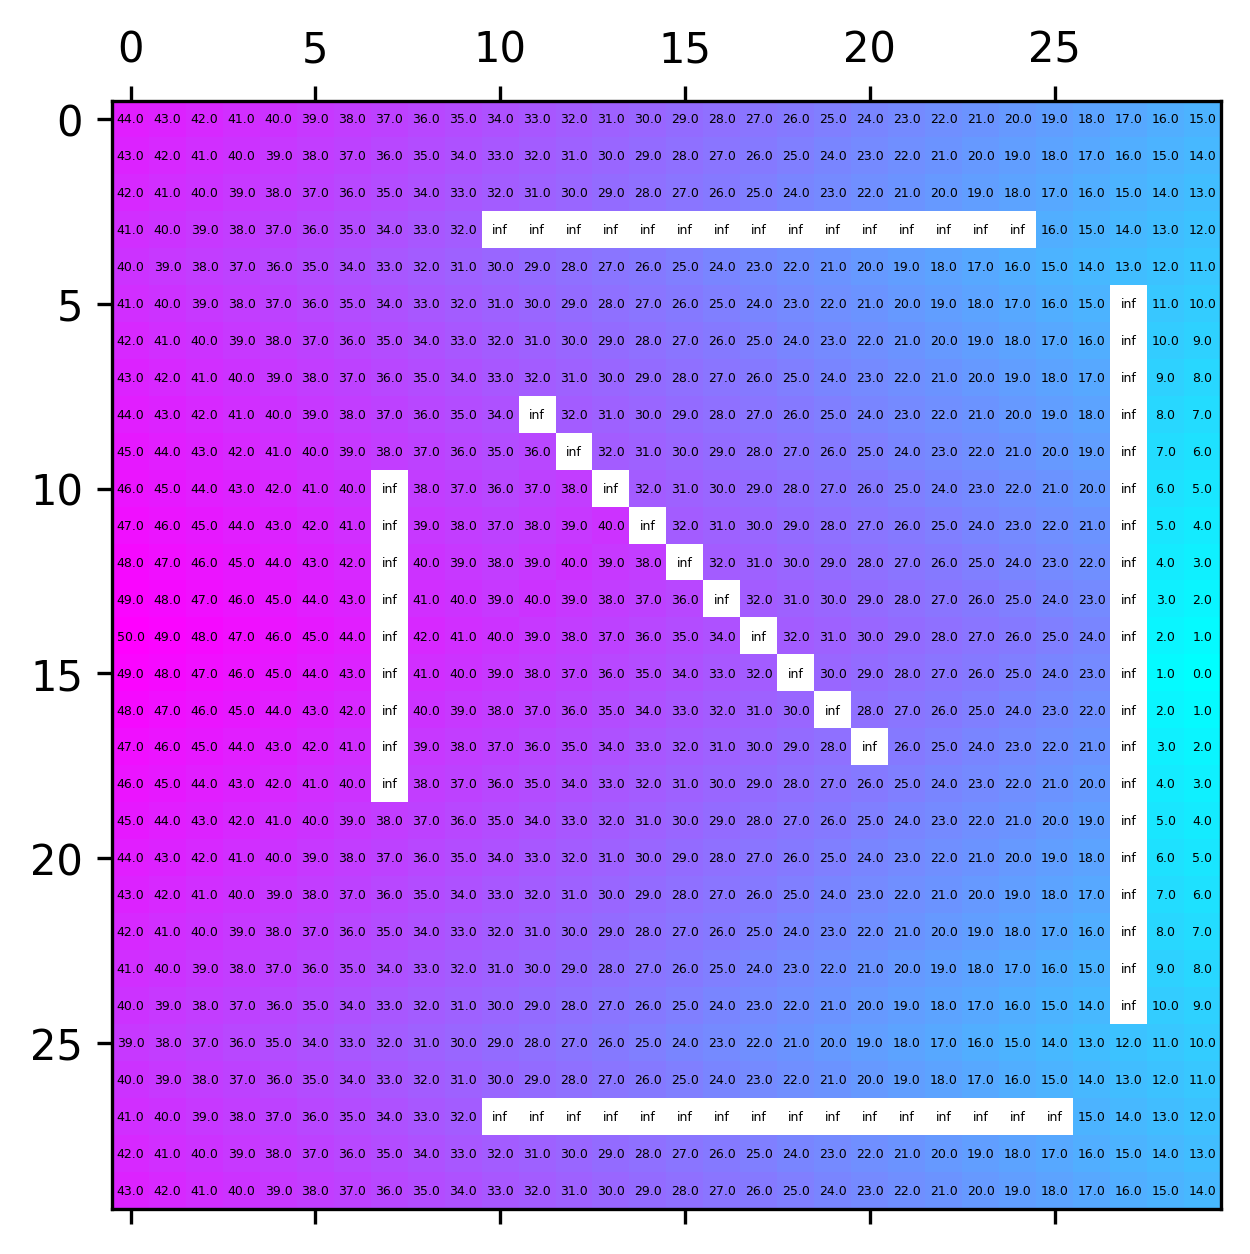

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.matshow(G_star, cmap='cool')

for i in range(30):
    for j in range(30):
        c = G_star[j, i]
        ax.text(i, j, str(c), va='center', ha='center', fontsize=3)
plt.show()

In [ ]:
print(action_space)

[(-1, 0), (1, 0), (0, -1), (0, 1)]


In [ ]:
arrow_dict={}
arrow_dict[0] ='↑'
arrow_dict[1] ='←'
arrow_dict[2] ='↓'
arrow_dict[3] ='→'
arrow_dict[-1] = 'T'
arrow_dict[np.inf]='obs'

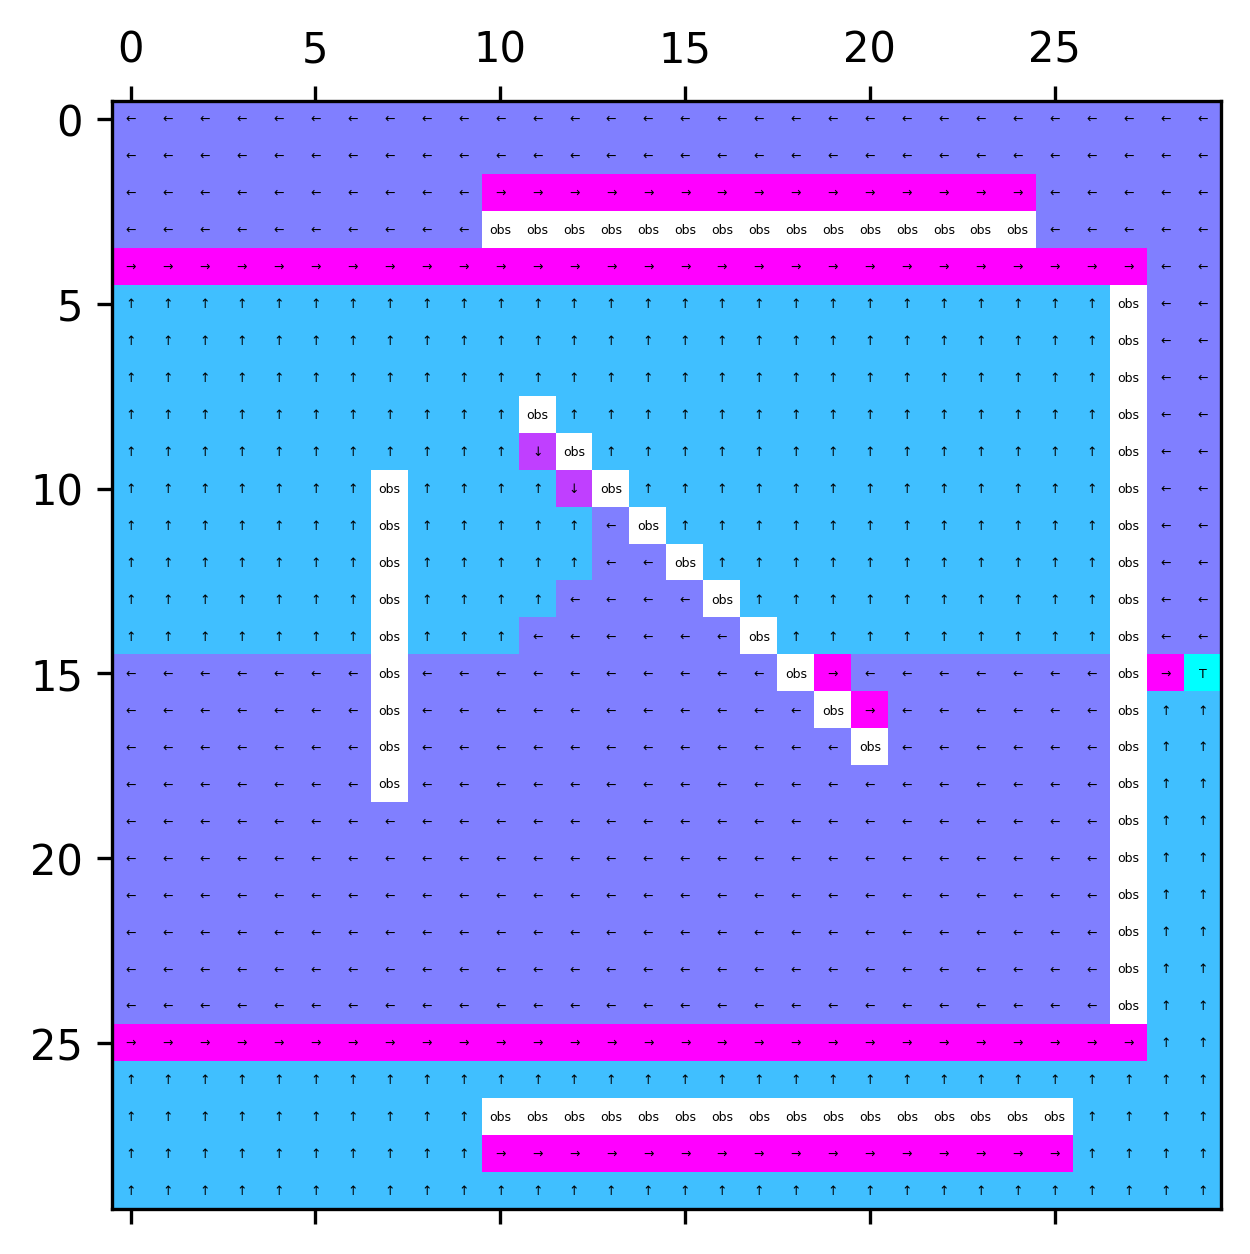

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.matshow(policy, cmap='cool')

for i in range(30):
    for j in range(30):
        c = policy[j, i]
        ax.text(i, j, str(arrow_dict[c]), va='center', ha='center', fontsize=3)
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
evader_start_default

(11, 6)

In [ ]:
# --- Игровой цикл с записью видео ---
frames = []
pbar = tqdm(range(100))
x_e = tuple(evader_start_default)
x_p = tuple(pursuer_start_default)
goal = goal_default

for s in pbar:
    # Получаем RGB-кадр
    frame_rgb = plot_joint_enviroment_rgb(maze_default, x_e, x_p, goal)
    frames.append(frame_rgb)

    # Движение уклоняющегося
    u_e = action_space[int(policy[x_e])]  # default_policy without taking into account the pursuer
    x_e, _ = transition_function(maze_default, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break

    # Движение преследователя
    x_p = pursuer_transition(maze_default, x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break

    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')

# Финальный кадр
frame_rgb = plot_joint_enviroment_rgb(maze_default, x_e, x_p, goal)
frames.append(frame_rgb)

# Сохранение видео
os.makedirs("videos", exist_ok=True)
video_path = "videos/scape_solve.mp4"
imageio.mimsave(video_path, frames, fps=10)
print(f"Видео сохранено как {video_path}")

x_e: (np.int64(15), np.int64(28)), x_p: (np.int64(7), np.int64(21)), distance to goal: 1.00 distance to pursuer: 10.63:  40%|████      | 40/100 [00:02<00:03, 17.47it/s]


WIN!
Видео сохранено как videos/scape_solve.mp4


In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Находим все .mp4 файлы в папке 'videos' и сортируем их по времени изменения (самый свежий — последний)
video_paths = sorted(
    [s for s in Path('videos').iterdir() if s.suffix == '.mp4'],
    key=lambda f: f.stat().st_mtime
)

if not video_paths:
    print("Видео не найдены в папке 'videos'.")
else:
    video_path = video_paths[-1]
    print(f"Воспроизведение видео: {video_path.name}")

    if 'google.colab' in sys.modules:
        with video_path.open('rb') as fp:
            mp4 = fp.read()
        data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    else:
        data_url = str(video_path)

    display(HTML(f"""
    <video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
    </video>
    """))

Воспроизведение видео: scape_solve.mp4


In [ ]:
import numpy as np
import math
from typing import Tuple

from collections import defaultdict

def available_children(node, Children, env):
    """
    Возвращает список допустимых дочерних узлов (соседних состояний) из заданного узла.
    Учитывает, что узлы не должны быть уже в дереве (избегаем циклов).
    """
    #print('Paren', Parents)
    #print(node, 'node')
    x = node  # текущая позиция (y, x)
    children_node = []  # список возможных дочерних позиций
    for a in action_space:  # перебираем все возможные действия (вверх, вниз, влево, вправо)
        x_next, obs_chk = transition_function(env, x, a)  # пробуем выполнить действие
        # если переход возможен (не в стену) и новая позиция не в дереве
        if (obs_chk == True) and (x_next not in Children):
            children_node.append(x_next)  # добавляем в список дочерних
    return children_node


def dist_nodes(q1, q2):
    """
    Вычисляет манхэттенское расстояние между двумя точками (y, x).
    """
    x1, y1 = q1  # координаты первой точки (y, x)
    x2, y2 = q2  # координаты второй точки (y, x)
    return np.abs(x2 - x1) + np.abs(y2 - y1)  # сумма разностей по осям

def calc_reward(x_e, x_p, goal, default_policy, env):
    """
    Функция симуляции для MCTS. Моделирует развитие эпизода от заданного состояния (x_e, x_p)
    с использованием политики default_policy для уклоняющегося.
    Возвращает числовую награду.
    """
    iter_ = 0  # счётчик шагов симуляции
    cum_sum = 0  # накопленная награда

    while True:
        # Выбираем действие для уклоняющегося на основе политики (индекс в action_space)
        u_e = action_space[int(default_policy[x_e])]  # default_policy without taking into account the pursuer
        # Выполняем переход уклоняющегося
        x_e, _ = transition_function(maze_default, x_e, u_e)
        # Выполняем переход преследователя (он следует за уклоняющимся)
        x_p = pursuer_transition(maze_default, x_e, x_p)

        # Если уклоняющийся ещё не достиг цели, добавляем награду (обратно пропорционально расстоянию)
        if x_e != goal:
            cum_sum += 0.1 / dist_nodes(x_e, goal)

        # Проверяем условия завершения симуляции
        if x_e == goal:
            R = 100 + cum_sum - iter_  # большая награда за достижение цели
            break
        if x_e == x_p:
            R = 0  # наказание за поимку
            break
        if iter_ > 50:
            R = cum_sum - iter_  # штраф за слишком долгую симуляцию
            break
        iter_ += 1  # увеличиваем счётчик шагов
    return R


def mcts_with_pursuer(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple, k_budget, default_policy) -> Tuple:
    """
    Monte-Carlo Tree Search с учётом преследователя.
    env is the grid enviroment
    x_e evader
    x_p pursuer
    goal is the goal state
    """
    # Инициализация ключевых структур данных MCTS
    Q = defaultdict(int)  # суммарная награда, полученная после посещения узла
    N = defaultdict(int)  # количество посещений узла
    Children = {} # словарь: узел -> [список дочерних узлов]
    Parent_table = {} # таблица родителей
    x_init_p = x_p  # начальная позиция преследователя
    x_init_e = x_e  # начальная позиция уклоняющегося

    #Parent_table[x_] = x_init_e
    for k in range(k_budget):  # основной цикл MCTS: k_budget итераций
        ################# select #######################
        path = []  # путь от корня до листа
        #node = (x_p, 1) # 0 is index for us, 1 is index for  pursuer
        node = x_init_e  # начинаем спуск от начальной позиции уклоняющегося
        x_p = x_init_p  # текущая позиция преследователя на этом пути
        #i = 0
        while True:
            path.append(node)  # добавляем текущий узел в путь
            if node not in Children or not Children[node]:  # если узел не раскрыт или нет детей
                # node is either unexplored or terminal
                break
            unexplored = Children[node] - Children.keys() # список детей, которые ещё не были в дереве
            if unexplored:
                n = unexplored.pop()  # выбираем первый непосещённый ребёнок
                path.append(n)  # добавляем его в путь
                break
            #node = self._uct_select(node)  # descend a layer deeper
            # All children of node should already be expanded:
            assert all(n in Children for n in Children[node])  # проверяем, что все дети уже в дереве
            log_N_vertex = math.log(N[node])  # логарифм числа посещений текущего узла
            def uct(n):
                # формула UCT (Upper Confidence bound for Trees) для выбора узла
                return Q[n] / N[n] + math.sqrt(log_N_vertex / N[n])
            node = max(Children[node], key=uct)  # выбираем ребёнка с максимальным UCT
            x_p = pursuer_transition(env, node, x_p)  # обновляем позицию преследователя вдоль пути
            #if i>50:
                #break

        #print('DICT', Children)
        #print(Parent_table)
        leaf = path[-1]  # листовой узел, до которого дошёл спуск
        #x_cur, phase = leaf
        #x_cur_parent, phase_parent = Parent_table[leaf]

        ################### expand leaf #######################
        #Expand selected node
        if leaf in Children:
            pass # уже раскрыт
        else:
            list_of_children = available_children(leaf, Children, env)  # находим возможных детей
            Children[leaf] = list_of_children #TODO  # добавляем их в дерево
            for n in list_of_children:
                Parent_table[n] = leaf  # записываем родителя

        x_e = leaf  # теперь x_e = лист, из которого начнётся симуляция
        ####################### simulate ########################
        reward = calc_reward(x_e, x_p, goal, default_policy, env)  # запускаем симуляцию и получаем награду
        ################### backpropagate ######################
        #update branch with reward
        for node in reversed(path):  # обновляем статистику (N и Q) для всех узлов на пути назад
            x = node
            N[node] += 1  # увеличиваем счётчик посещений
            Q[node] += reward # 1 for me is 0 for my enemy, and vice versa  # добавляем награду
            # (для уклоняющегося — чем больше, тем лучше, для преследователя — наоборот)

    # finally select
    def score(n):
        # функция для оценки узла: средняя награда
        if N[n] == 0:
            return np.inf  # если не посещался — приоритет
        return Q[n] / N[n]  # средняя награда
    x_opt = max(Children[x_init_e], key=score)  # выбираем лучшего ребёнка корня
    # возвращаем действие (dy, dx), которое приводит к x_opt
    return (x_opt[0] - x_init_e[0], x_opt[1] - x_init_e[1])

In [ ]:
# --- Игровой цикл с записью видео ---
frames = []
pbar = tqdm(range(100))
x_e = tuple(evader_start_default)  # замените на нужную начальную позицию
x_p = tuple(pursuer_start_default) # замените на нужную начальную позицию
goal = goal_default                # замените на нужную цель

for s in pbar:
    # Получаем RGB-кадр
    frame_rgb = plot_joint_enviroment_rgb(maze_default, x_e, x_p, goal)
    frames.append(frame_rgb)

    # Выбираем действие через MCTS (с учётом преследователя)
    u_e = mcts_with_pursuer(
        env=maze_default,
        x_e=x_e,
        x_p=x_p,
        goal=goal,
        k_budget=100,
        default_policy=policy  # ваша политика из Дейкстры
    )
    print(u_e)

    # Движение уклоняющегося
    x_e, _ = transition_function(maze_default, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break

    # Движение преследователя
    x_p = pursuer_transition(maze_default, x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break

    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')

# Финальный кадр
frame_rgb = plot_joint_enviroment_rgb(maze_default, x_e, x_p, goal)
frames.append(frame_rgb)

# Сохранение видео
os.makedirs("videos", exist_ok=True)
video_path = "videos/scape_solve.mp4"
imageio.mimsave(video_path, frames, fps=10)
print(f"Видео сохранено как {video_path}")

x_e: (np.int64(10), np.int64(5)), x_p: (np.int64(9), np.int64(25)), distance to goal: 24.52 distance to pursuer: 20.02:   2%|▏         | 2/100 [00:00<00:17,  5.73it/s]

(np.int64(0), np.int64(-1))
(np.int64(-1), np.int64(0))


x_e: (np.int64(9), np.int64(6)), x_p: (np.int64(11), np.int64(25)), distance to goal: 23.77 distance to pursuer: 19.10:   4%|▍         | 4/100 [00:00<00:16,  5.83it/s]

(np.int64(0), np.int64(1))
(np.int64(-1), np.int64(0))


x_e: (np.int64(9), np.int64(8)), x_p: (np.int64(14), np.int64(25)), distance to goal: 21.84 distance to pursuer: 17.72:   6%|▌         | 6/100 [00:01<00:15,  6.00it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(8), np.int64(9)), x_p: (np.int64(14), np.int64(25)), distance to goal: 21.19 distance to pursuer: 17.09:   8%|▊         | 8/100 [00:01<00:15,  6.11it/s]

(np.int64(0), np.int64(1))
(np.int64(-1), np.int64(0))


x_e: (np.int64(7), np.int64(10)), x_p: (np.int64(14), np.int64(25)), distance to goal: 20.62 distance to pursuer: 16.55:  10%|█         | 10/100 [00:01<00:14,  6.12it/s]

(np.int64(-1), np.int64(0))
(np.int64(0), np.int64(1))


x_e: (np.int64(7), np.int64(12)), x_p: (np.int64(14), np.int64(25)), distance to goal: 18.79 distance to pursuer: 14.76:  12%|█▏        | 12/100 [00:01<00:13,  6.44it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(7), np.int64(14)), x_p: (np.int64(14), np.int64(25)), distance to goal: 17.00 distance to pursuer: 13.04:  14%|█▍        | 14/100 [00:02<00:12,  6.63it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(7), np.int64(16)), x_p: (np.int64(12), np.int64(25)), distance to goal: 15.26 distance to pursuer: 10.30:  16%|█▌        | 16/100 [00:02<00:13,  6.45it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(7), np.int64(16)), x_p: (np.int64(12), np.int64(25)), distance to goal: 15.26 distance to pursuer: 10.30:  18%|█▊        | 18/100 [00:02<00:12,  6.77it/s]

(np.int64(-1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(7), np.int64(17)), x_p: (np.int64(13), np.int64(25)), distance to goal: 14.42 distance to pursuer: 10.00:  19%|█▉        | 19/100 [00:03<00:11,  6.86it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(6), np.int64(17)), x_p: (np.int64(12), np.int64(25)), distance to goal: 15.00 distance to pursuer: 10.00:  20%|██        | 20/100 [00:03<00:13,  5.87it/s]

(np.int64(-1), np.int64(0))


x_e: (np.int64(6), np.int64(18)), x_p: (np.int64(13), np.int64(25)), distance to goal: 14.21 distance to pursuer: 9.90:  21%|██        | 21/100 [00:03<00:15,  5.22it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(6), np.int64(19)), x_p: (np.int64(12), np.int64(25)), distance to goal: 13.45 distance to pursuer: 8.49:  22%|██▏       | 22/100 [00:03<00:16,  4.74it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(7), np.int64(19)), x_p: (np.int64(13), np.int64(25)), distance to goal: 12.81 distance to pursuer: 8.49:  23%|██▎       | 23/100 [00:03<00:16,  4.58it/s]

(np.int64(1), np.int64(0))


x_e: (np.int64(7), np.int64(20)), x_p: (np.int64(14), np.int64(25)), distance to goal: 12.04 distance to pursuer: 8.60:  24%|██▍       | 24/100 [00:04<00:16,  4.47it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(6), np.int64(20)), x_p: (np.int64(15), np.int64(25)), distance to goal: 12.73 distance to pursuer: 10.30:  25%|██▌       | 25/100 [00:04<00:16,  4.50it/s]

(np.int64(-1), np.int64(0))


x_e: (np.int64(5), np.int64(20)), x_p: (np.int64(16), np.int64(25)), distance to goal: 13.45 distance to pursuer: 12.08:  26%|██▌       | 26/100 [00:04<00:16,  4.38it/s]

(np.int64(-1), np.int64(0))


x_e: (np.int64(5), np.int64(21)), x_p: (np.int64(15), np.int64(25)), distance to goal: 12.81 distance to pursuer: 10.77:  27%|██▋       | 27/100 [00:04<00:17,  4.26it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(5), np.int64(22)), x_p: (np.int64(13), np.int64(25)), distance to goal: 12.21 distance to pursuer: 8.54:  28%|██▊       | 28/100 [00:05<00:16,  4.24it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(5), np.int64(23)), x_p: (np.int64(14), np.int64(25)), distance to goal: 11.66 distance to pursuer: 9.22:  29%|██▉       | 29/100 [00:05<00:18,  3.89it/s]

(np.int64(0), np.int64(1))


x_e: (np.int64(5), np.int64(25)), x_p: (np.int64(12), np.int64(25)), distance to goal: 10.77 distance to pursuer: 7.00:  31%|███       | 31/100 [00:05<00:16,  4.23it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(4), np.int64(26)), x_p: (np.int64(10), np.int64(25)), distance to goal: 11.40 distance to pursuer: 6.08:  33%|███▎      | 33/100 [00:06<00:12,  5.22it/s]

(np.int64(0), np.int64(1))
(np.int64(-1), np.int64(0))


x_e: (np.int64(4), np.int64(28)), x_p: (np.int64(9), np.int64(26)), distance to goal: 11.05 distance to pursuer: 5.39:  35%|███▌      | 35/100 [00:06<00:11,  5.86it/s]

(np.int64(0), np.int64(1))
(np.int64(0), np.int64(1))


x_e: (np.int64(6), np.int64(28)), x_p: (np.int64(8), np.int64(26)), distance to goal: 9.06 distance to pursuer: 2.83:  37%|███▋      | 37/100 [00:06<00:10,  6.07it/s]

(np.int64(1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(8), np.int64(28)), x_p: (np.int64(7), np.int64(25)), distance to goal: 7.07 distance to pursuer: 3.16:  39%|███▉      | 39/100 [00:07<00:09,  6.62it/s]

(np.int64(1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(10), np.int64(28)), x_p: (np.int64(7), np.int64(25)), distance to goal: 5.10 distance to pursuer: 4.24:  41%|████      | 41/100 [00:07<00:11,  5.17it/s]

(np.int64(1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(12), np.int64(28)), x_p: (np.int64(7), np.int64(25)), distance to goal: 3.16 distance to pursuer: 5.83:  43%|████▎     | 43/100 [00:07<00:09,  6.08it/s]

(np.int64(1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(14), np.int64(28)), x_p: (np.int64(7), np.int64(23)), distance to goal: 1.41 distance to pursuer: 8.60:  45%|████▌     | 45/100 [00:08<00:07,  6.89it/s]

(np.int64(1), np.int64(0))
(np.int64(1), np.int64(0))


x_e: (np.int64(15), np.int64(28)), x_p: (np.int64(7), np.int64(22)), distance to goal: 1.00 distance to pursuer: 10.00:  46%|████▌     | 46/100 [00:08<00:09,  5.48it/s]


(np.int64(1), np.int64(0))
(np.int64(0), np.int64(1))
WIN!
Видео сохранено как videos/scape_solve.mp4


In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Находим все .mp4 файлы в папке 'videos' и сортируем их по времени изменения (самый свежий — последний)
video_paths = sorted(
    [s for s in Path('videos').iterdir() if s.suffix == '.mp4'],
    key=lambda f: f.stat().st_mtime
)

if not video_paths:
    print("Видео не найдены в папке 'videos'.")
else:
    video_path = video_paths[-1]
    print(f"Воспроизведение видео: {video_path.name}")

    if 'google.colab' in sys.modules:
        with video_path.open('rb') as fp:
            mp4 = fp.read()
        data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    else:
        data_url = str(video_path)

    display(HTML(f"""
    <video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
    </video>
    """))

Воспроизведение видео: scape_solve.mp4
